# 1. Data and Notebook setup

In [13]:
from statistics import mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

In [46]:
df = pd.read_csv("IMA Recommendation Simulation Data.csv")
print(df.head(5))
#find the shape of data
shape = df.shape
print(shape)
#find CurrentCondition categories
uniqueVals = df['CurrentCondition'].unique()
size_currentCondition = uniqueVals.size
df['CurrentCondition'].value_counts()
print(uniqueVals)
print(size_currentCondition)

   Unnamed: 0                        request_id  week_id weekday  miles  \
0           0  c2653eda11cd4d94879d1946392eb2b5        4     Sat   1856   
1           1  65e3dcc84a2246e68ea8636a967b31b2        3     Mon     56   
2           2  0a86f005640a4204b46c95ca033a7ced        1     Fri    259   
3           3  1105b4bc7b444f7985d4ad810e7acbc2        3     Thu     71   
4           4  de538100bb0f4137961b9551640ef35e        3     Fri   1182   

  order_equipment_type  order_distance  order_num_stops  order_origin_weight  \
0                    V          1848.0                2              40000.0   
1                    V            47.0                2              12729.0   
2                    V           255.0                2              44176.0   
3                    V            68.0                2              39847.0   
4                    R          1183.0                2              34912.0   

   lead_days  color  origin_dat_ref  dest_dat_ref  rate_norm  est_co

1a. What is the shape of the data file you were given? 

The shape of this data is (161563, 16). 

1b. How many unique categories are there for CurrentCondition? 

There are 8 unique categories, which are: 'Accepted' 'Rejected' 'Withdrawn' 'Waiting On Acceptance' 'Cancelled', 'nan', 'Waiting On Recommendation' and 'NoPace'

# 2. Exploratory Data Analysis

In [4]:
#2a
uniqueVals2 = df['request_id'].nunique()
print(uniqueVals2)

161562


2a. Is request_id unique? 

No, it is not. The dimension of the dataset is (161563, 16), which request_id only has 161562 unique values, so there is 1 row that repeats.

In [5]:
#2b, use .info to look for nulll
df.info()
new_df = df.dropna(subset=['rate_norm','est_cost_norm','order_distance'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161563 entries, 0 to 161562
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            161563 non-null  int64  
 1   request_id            161563 non-null  object 
 2   week_id               161563 non-null  int64  
 3   weekday               161563 non-null  object 
 4   miles                 161563 non-null  int64  
 5   order_equipment_type  161563 non-null  object 
 6   order_distance        156885 non-null  float64
 7   order_num_stops       161563 non-null  int64  
 8   order_origin_weight   161544 non-null  float64
 9   lead_days             161563 non-null  int64  
 10  color                 161563 non-null  object 
 11  origin_dat_ref        161563 non-null  int64  
 12  dest_dat_ref          161563 non-null  int64  
 13  rate_norm             161382 non-null  float64
 14  est_cost_norm         161524 non-null  float64
 15  

2b. Is there any missing data? If so, which columns have missing data?

Yes there are missing data in 5 columns, the columns with missing data are order_distance, order_origin_weight, rate_norm, est_cost_norm, and CurrentCondition

0.805156751657781

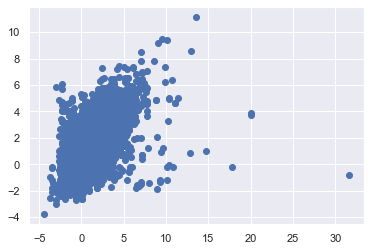

In [6]:
#2c on pair 1
plt.scatter(new_df.rate_norm, new_df.est_cost_norm)
x_ratenorm = new_df.rate_norm
y_estcost = new_df.est_cost_norm
x_ratenorm.corr(y_estcost)

0.9822956149941414

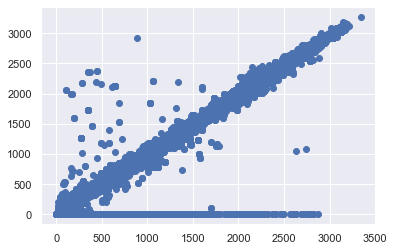

In [7]:
#2c on pair 2
plt.scatter(new_df.miles, new_df.order_distance)
x_miles = new_df.miles
y_order = new_df.order_distance
x_miles.corr(y_order)

2c. Are there any features you would consider highly correlated? 

The two pairs of features I would consider higly correlated are 'rate_norm' with 'est_cost_norm' and 'miles' with 'order_distance. I selected these 'rate_norm' with 'est_cost_norm' based on the given description of the features, without much information, there is some way to estimate how much C.H Robinson will pay to carriers based on the price customers pay, and should not be random. The second pair I beleived to be highly correlated is because also based on the given description. If a customer most likely would not look to ship a good if they did not think the distance between the original location and the destination was a reachable distance for a truck driver. From the scatterplot of the two pairs, we can see 'miles' with 'order_distance' have a much stronger positive correlation with correlation rate of 0.9822 compared to 'rate_norm' with 'est_cost_norm' with correlation rate of 0.8052. This is most likely because C.H Robinson either under or overestimate the price for each order's carrier, which will give a bigger correlation gap. 

Since there is missing data from these columns, omitting the missing data resulted in a slightly higher correlation rate. Initally the correlation rate between 'rate_norm' and 'est_cost_norm' was 0.803 and the correlation rate bewteen 'miles' and 'order_distance' was 0.98227, with change on the 5th digit. 

<AxesSubplot:>

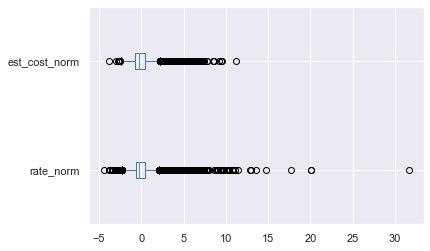

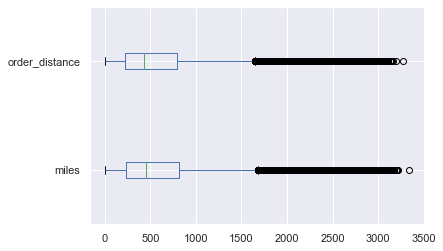

In [43]:
#2d on 1st visualization
new_df[['rate_norm', 'est_cost_norm']].plot.box(vert = False, grid = True)
new_df[['miles', 'order_distance']].plot.box(vert = False, grid = True)

<AxesSubplot:xlabel='rate_norm', ylabel='est_cost_norm'>

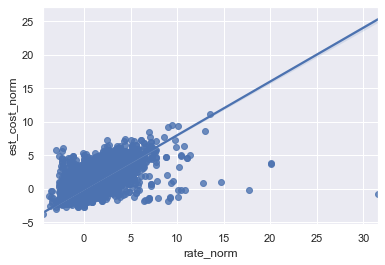

In [48]:
#2d on second visualization 
sns.regplot(x='rate_norm', y = 'est_cost_norm', data=new_df)

<AxesSubplot:xlabel='miles', ylabel='order_distance'>

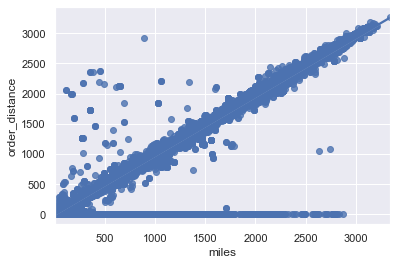

In [47]:
sns.regplot(x='miles', y = 'order_distance', data=new_df)

2d. The boxplots in both pairs measures similarly. In pair 1, the outlier in 'rate_norm' exceeds 'est_cost_norm', but interquartile range appears to have similar measuress. In pair 2, we can see the two boxplots match up a lot more, even with outlier data, with 'miles' only exceeding slightly than 'order_distance' in comparison of outliers. This is not surprising as seen in part 2c, where in pair 2, have a much higher correlation rate. 

Best fitted line in a scatter plot will give us a better idea of the relationship between two features. In pair 1, it appears as most of the data is along the bottom left with a positive trend, but as the line increases, there are less data points. In pair 2, we see a much stronger correlation where most data points center around the fitted line. 

# 3. Spit into test and train 

In part 3, there are approximately 18-20% of the original data omitted including 'nan'. The goal of the company is to maximize profit based on paying less to carrier than customers paying to company, only two categories in CurrentCondition will tell us whether the order was accepted by C.H Robinson or not, which is 'Accepted' or 'Rejected'. When a customer withdraws or cancels the order, which the company does not gain profit from nor is it the company's choice, hence it will not give accurate analysis. One of the issues with omitting this data is undersampling, which will give us a more bias and less accurate analysis. A solution to omiting this data is to oversample, which can also give a bias analysis and cause overfitting. 

In [33]:
#will be under-sampling by taking out nan and information with neither accepted or rejected
#disadvantage-sampling may be bias, so can give inaccurate data
curr_df = df[df['CurrentCondition'].str.contains('Withdrawn|Waiting On Acceptance|Cancelled|Waiting On Recommendation|NoPace')==False]
class_df = curr_df.dropna(subset=['CurrentCondition','rate_norm','est_cost_norm', 'miles', 'order_distance'])

#set up split for train/test
from sklearn.model_selection import train_test_split
#x values using rate_norm and est_cost_norm
x= class_df[['rate_norm', 'est_cost_norm','miles', 'order_distance']].values
#y values, setting 'accepted' to be 1 and anything else to be -1('rejected')
y= np.where(class_df['CurrentCondition'].str.contains("Accepted", na=False),1,-1)
y=pd.Series(y)

#Use oversampling to make up for the missing data, but will overestimate accuracy 
#import oversampling library 
from sklearn.datasets import make_classification
from imblearn import over_sampling
from collections import Counter

# resampling x, y, uncomment following lines and change x,y in train_test to x_ros, y_ros to see oversampling results
#ros = over_sampling.RandomOverSampler()
#x_ros, y_ros = ros.fit_resample(x, y)
x_training_data, x_testing_data, y_training_data, y_testing_data = train_test_split(x,y,test_size=0.3)
#print(Counter(y_ros))

# 4. Build Two Classifiers: knn, Naive Bayes Algorithm

In [49]:
#Knn 
from sklearn.neighbors import KNeighborsClassifier
knn_model=KNeighborsClassifier(n_neighbors=1)
knn_model.fit(x_training_data, y_training_data)
predictions = knn_model.predict(x_testing_data)

#import library for report and confusion matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#print results 
print(classification_report(y_testing_data, predictions))
print(confusion_matrix(y_testing_data, predictions))



              precision    recall  f1-score   support

          -1       0.67      0.67      0.67     10693
           1       0.87      0.87      0.87     28061

    accuracy                           0.82     38754
   macro avg       0.77      0.77      0.77     38754
weighted avg       0.82      0.82      0.82     38754

[[ 7194  3499]
 [ 3590 24471]]


In [50]:
#Naive Bayes Algorithm 
#Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
NB_model = GaussianNB()
NB_model.fit(x_training_data, y_training_data)

#Predicting the Test set results
y_pred = NB_model.predict(x_testing_data)

#print result and Confusion Matrix 
print(classification_report(y_testing_data, y_pred))
print(confusion_matrix(y_testing_data, y_pred))  #10804, 10465

#4b
from sklearn.inspection import permutation_importance
imps = permutation_importance(classifier, x_testing_data, y_testing_data)
print('The feature importance based on permutation importance are:',imps.importances_mean)

              precision    recall  f1-score   support

          -1       0.54      0.00      0.00     10693
           1       0.72      1.00      0.84     28061

    accuracy                           0.72     38754
   macro avg       0.63      0.50      0.42     38754
weighted avg       0.67      0.72      0.61     38754

[[   13 10680]
 [   11 28050]]
The feature importance based on permutation importance are: [6.39933942e-04 7.49858079e-03 5.16075760e-05 1.18697425e-04]


4a. The two classifiers used are k-nearest neighbor(knn) resulting in 82% accuracy for k=1 and Naive Bayes algorithm(NB) resulting in 72% accuracy. It seems like knn performs better than NB because it has a higher percent of accuracy along with less type I and type II errrors for k=1. I believe knn is better since about 20% of the data has been omitted, hence the algorithm can use neighboring data to make predictions compared to NB, where NB assumes independence. Better in this context means percent of accuracy, amount of overall errors. 

4b. For NB, it seems 'est_cost_norm' is the best feature with the value 7.34375806e-03 using permutation importance. Since knn is a non-parametric algorithm, it is difficult to measure which is the best feature. I measured knn by taking out one feature at a time from x, taking out 'order_distance' yeilds the lowest accuracy of 79%, hence 'order_distance will be the best feature. 

4c. Yes, we should worry about overfitting with knn. I tested both alogrithms with oversampling method where knn had an increased accuracy of 90% at k=1 compared to 82% for k=1. This makes sense, because the additional data used for knn method is being predicted on surrounding data. In NB, the percentage of accuracy actually decreased to 54% accuracy, which does not take into account of surrounding data.

# 5. Context and Critical Reflection

1. Would a data scientist working on this dataset use the full dataset including categories in CurrentConditions that do not see useful. Or how would they go about using the dataset?

2. How would a data scientist improve the accuracy of this data without overfitting?

If I was an employee, I would first research other possible techniques, ways to approach the problem, and comparing similar dataset. I would then brainstrom based on the research I have done on the topic to and to implement ideas I have. If I am still encountering difficulties after, I will seek out to peers for help. 